# MSDM5056 Tutorial 4 - Large Scale Structures of Network

## Table of Contents

1. Degree Distribution
2. More on Power Law
3. Clustering
4. Assortativity

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

---
# 1. Degree Distribution

First we will play with the network $\mathcal{P}$, [the collaboration network among physicists from 1995 to 1999](http://www-personal.umich.edu/~mejn/netdata/cond-mat.zip) [Newman, M. E. J.: The structure of scientific collaboration networks. Proc. Natl. Acad. Sci. USA 98, 404-409 (2001)].

In [3]:
physicists = nx.convert_node_labels_to_integers(nx.read_gml('data_set/cond-mat/cond-mat.gml'), label_attribute='name')

physicists.remove_nodes_from(list(nx.isolates(physicists))) # some nodes are originally isolated

Some physicists have never colloborated others. The isolated nodes representing them are removed from the network for simplicity.

In [4]:
N = physicists.number_of_nodes()
E = physicists.number_of_edges()

print('After removing isolated nodes,')
print('Number of nodes : '+str(N))
print('Number of edges : '+str(E))
print('Density of edges: {:.2e}'.format(nx.density(physicists)))
print('Average degree  : {:.3g}'.format(sum(k for n,k in physicists.degree)/N))

After removing isolated nodes,
Number of nodes : 16264
Number of edges : 47594
Density of edges: 3.60e-04
Average degree  : 5.85


## 1.1 Power law

Degree distribution $P(k)$ is often an interesting quantity in a large network. If we plot it against degree $k$, we often see a heavy tail, which signifies some power law. Indeed, we can see a negatively linear trend if we make a log-log plot of $P(k)$ against $k$.

\begin{align*}
    \ln\left.P(k)\right. &\sim -a\ln\left.k\right. \left(a>0\right) \\
        \Rightarrow P(k) &\sim k^{-a}
\end{align*}

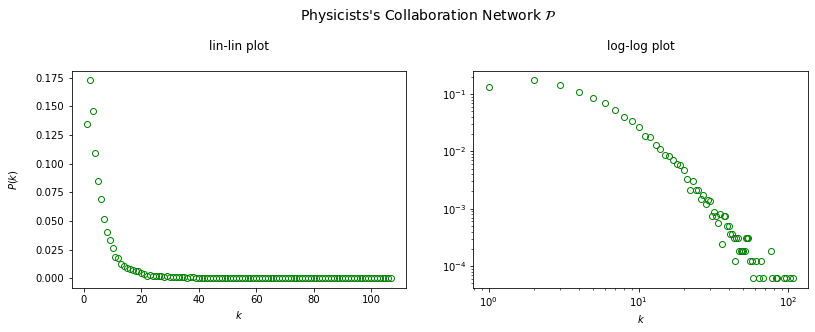

In [5]:
degrees = [k for n,k in physicists.degree]
kMin,kMax = min(degrees),max(degrees)
kRng = np.arange(kMin,kMax+1)
degree_histogram = [n/N for n in nx.degree_histogram(physicists)[1:]]

fig,ax = plt.subplots(1,2, figsize=(6*2.2,4))
ax[0].plot(kRng, degree_histogram, 'go', mfc='none')
ax[0].set_ylabel('$P(k)$\n')
ax[0].set_title('lin-lin plot\n')
ax[1].loglog(kRng, degree_histogram, 'go', mfc='none')
ax[1].set_title('log-log plot\n')
for a in ax:
    a.set_xlabel('$k$')
fig.suptitle('Physicists\'s Collaboration Network $\mathcal{P}$', y=1.1, fontsize=14)
plt.show()

Observing power law degree distribution in networks is not trivial at all, in comparison to a network that is generated randomly. (As a preview to lecture 6, ) the degree distribution of a random network with average degree $\langle k \rangle$ will generally follow the Poisson distribution 

\begin{align*}
P_\mathcal{R}(k) = \frac{\langle k \rangle^k }{k!}e^{-\langle k \rangle }
\end{align*}

In NetworkX, a random network can be created by `gnm_random_graph(n, m)`, where $m$ is the number of edges and $n$ is the number of nodes on the graph. And so $\langle k \rangle = \frac{2m}{n}$. We will also talk about this in lecture 6.


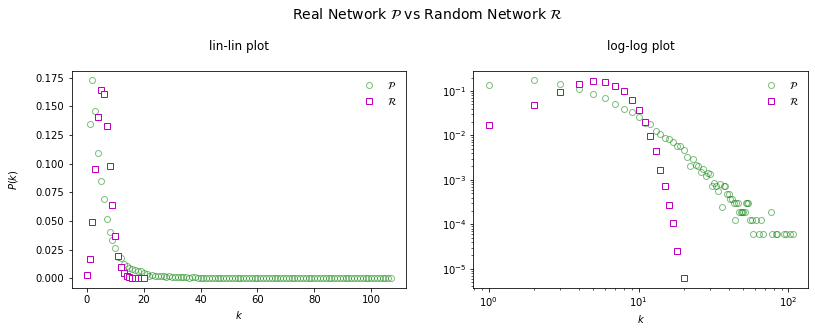

In [6]:
rnd_degrees = []
for trial in range(10):
    random = nx.gnm_random_graph(N, E, seed=5056+trial)
    rnd_degrees.extend([k for n,k in random.degree])
rnd_degree_histogram = np.bincount(rnd_degrees)/10/N

fig,ax = plt.subplots(1,2, figsize=(6*2.2,4))
ax[0].plot(kRng, degree_histogram, 'go', mfc='none',alpha=.5)
ax[0].plot(rnd_degree_histogram, 'ms', mfc='w')
ax[1].loglog(kRng, degree_histogram, 'go', mfc='none',alpha=.5)
ax[1].loglog(rnd_degree_histogram, 'ms', mfc='w')
ax[0].set_ylabel('$P(k)$\n')
for a in ax:
    a.set_xlabel('$k$')
    a.legend(['$\mathcal{P}$', '$\mathcal{R}$'], frameon=False)
ax[0].set_title('lin-lin plot\n')
ax[1].set_title('log-log plot\n')
fig.suptitle('Real Network $\mathcal{P}$ vs Random Network $\mathcal{R}$', y=1.1, fontsize=14)
plt.show()

Usually we will describe a random network having a bell-shaped degree distribution rather than a heavy tail. This indicates that **real networks are not random at all**.

## 1.2 Visualization

Although it is the most faithful to plot $P(k)$ at all available $k$, we usually bin our data before plotting. This has several advantages.

1. Binning smooths out the distribution.
2. Binning reduces the chance of having zeros, i.e. $P(k)=0$, which interrupt our log-log plot.
3. Binning tidies up the data, especially when $k$ spans a wide range.

However, there is no optimal rule to determine how to bin the data, so binning introduces inevitably much bias to our analysis. Check [Histogram](https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width) on Wikipedia for more information.

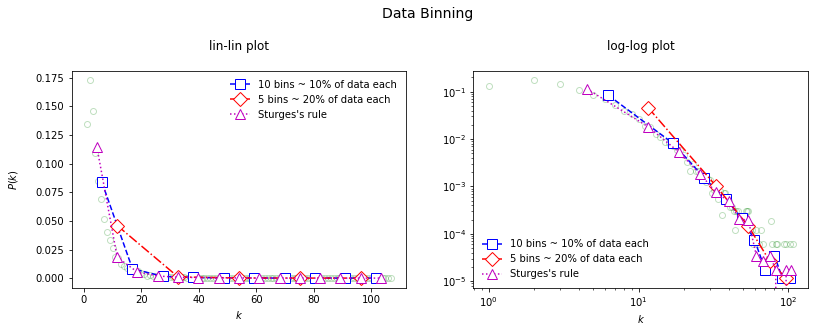

In [7]:
def np_histogram(data, ax, fmt, bins=10, log=False, **kwargs):
    probs,binEdges = np.histogram(data, bins, density=True)
    log = kwargs.pop('log', False)
    if log:
        centers = (binEdges[1:]*binEdges[:-1])**.5
    else:
        centers = (binEdges[1:]+binEdges[:-1])*.5
    ax.plot(centers, probs, fmt, **kwargs)

fig,ax = plt.subplots(1,2, figsize=(6*2.2,4))
ax[0].plot(kRng, degree_histogram, 'go', mfc='none', alpha=.25)
ax[1].loglog(kRng, degree_histogram, 'go', mfc='none', alpha=.25)
for a in ax:
    np_histogram(degrees, a, 'bs--', bins=10, ms=10, mfc='w',
                 label='10 bins ~ 10% of data each')
    np_histogram(degrees, a, 'rD-.', bins=5, ms=10, mfc='w',
                 label='5 bins ~ 20% of data each')
    np_histogram(degrees, a, 'm^:', bins='sturges', ms=10, mfc='w',
                 label='Sturges\'s rule')
    a.set_xlabel('$k$')
    a.legend(frameon=False)
ax[0].set_ylabel('$P(k)$\n')
ax[0].set_title('lin-lin plot\n')
ax[1].set_title('log-log plot\n')
fig.suptitle('Data Binning', y=1.1, fontsize=14)
plt.show()

We can see that linear binning distorts a log-log plot as it emphasizes too much on data points with a small $k$, so logarithmic binning should be used instead to show the heavy tail.

In fact, we usually prefer plotting the distribution's complimentary CDF (cCDF) $P(X>k)$, where $X$ denotes an arbitrary node's degree. If $P(k)\sim k^{-a}$, the corresponding cCDF also obeys some power law:

\begin{align*}
    P(X>k) \sim \int_k^\infty x^{-a} d{x}
           \sim \left(x^{-a+1}\right)^\infty_k \sim k^{-a+1} \,.
\end{align*}

While the cCDF display a heavy tail similarly, the end of the tail is much smoother, monotocally decreasing and definitely do not contain any zeros. It is much more convenient for fitting. 

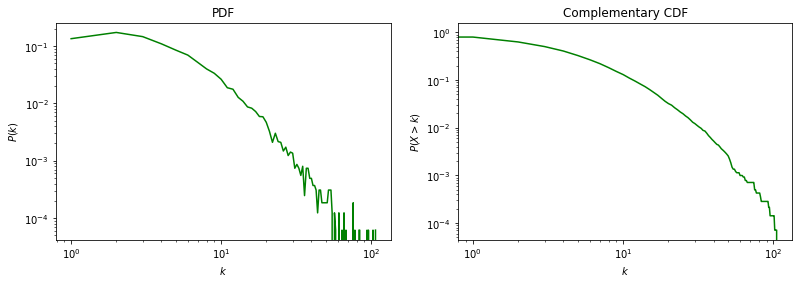

In [13]:
cCDF = np.cumsum([0]+degree_histogram[:0:-1])[::-1]
cCDF = np.true_divide(cCDF, cCDF[0])

fig,ax = plt.subplots(1,2, figsize=(6*2.2,4))
ax[0].loglog(kRng, degree_histogram, 'g-')
ax[0].set_xlabel('$k$')
ax[0].set_ylabel('$P(k)$')
ax[0].set_title('PDF')

ax[1].loglog(cCDF, 'g-')
ax[1].set_xlabel('$k$')
ax[1].set_ylabel('$P(X>k)$')
ax[1].set_title('Complementary CDF')
plt.show()

## 1.3 Degree exponent

For $P(k)\sim k^{-a}$, we refer to $a$ as the **degree exponent**. We may measure it by linear fitting to the tail of the cCDF on the log-log plot. Fitting the slope as $(-a+1)$ and y-intercept as $b$,

\begin{align*}
    \ln{P(X>k)} &= \left({-a+1}\right)\ln{k}+b \\
    P(X>k) &= e^b k^{-a+1}
\end{align*}

However it is not always so simple in practice. We can always judge ourselves the following questions:
- How do you choose the cutoff as the "start" of the tail?
- Is it possible that the heavy tail is just similar curves but not power law?

With the method of least squares,
a = 3.54 ± 0.07
b = 3.6 ± 0.3


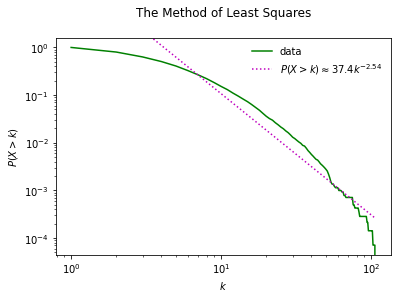

In [9]:
from scipy.optimize import curve_fit

(a,b),pcov = curve_fit(lambda lnk,a,b: lnk*(-a+1)+b, np.log(kRng[:-1]), np.log(cCDF[:-1]))
ls = ((a,np.sqrt(pcov[0,0])), (b,np.sqrt(pcov[1,1])))
print('With the method of least squares,')
print('a = {0:.{2}f} ± {1:.1g}'.format(ls[0][0],ls[0][1],len(str(int(1/ls[0][1])))))
print('b = {0:.{2}f} ± {1:.1g}'.format(ls[1][0],ls[1][1],len(str(int(1/ls[1][1])))))

plt.figure(figsize=(6,4))
plt.loglog(kRng, cCDF, 'g-', label='data')
ylim = plt.gca().get_ylim()
plt.loglog(kRng, np.exp(b)*kRng**(-a+1), 'm:',
           label=r'$P(X>k)\approx$'+'${:.3g}k$'.format(np.exp(b))
                +r'$^{'+'{:.3g}'.format(1-a)+r'}$')
plt.gca().set_ylim(ylim)
plt.legend(frameon=False)
plt.xlabel('$k$')
plt.ylabel('$P(X>k)$')
plt.title('The Method of Least Squares\n')
plt.show()

---
# 2. More on Power Law

"Power law" is just a generic term that describes any distribution that obeys $P(x)\sim x^{-a}$, but what does that little "$\sim$" mean? To make the relationship rigorous, we must specify some normalization constant $A$ in $P(x)=Ax^{-a}$ so that $\int_{-\infty}^{\infty}{P(x)dx}=1$. In fact, a number of distributions satisfy the canonical formula but differ from each other with $A$ due to their different supports of $x$, i.e. the domain of $x$ over which $P(x)>0$.

## 2.1 Pareto distribution

If $x\in\mathbb{R}$ and supports $[m,\infty)$, a power law corresponds to the Pareto distribution $f_P{(x; a, m)}$.

\begin{align*}
    A_P = \left( \int_m^\infty {x^{-a}dx} \right)^{-1}
        = \left[ \left(\dfrac{x^{-a+1}}{-a+1}\right)^\infty_{m} \right]^{-1}
        = \dfrac{a-1}{m^{-a+1}}
\end{align*}

Conventionally, the Pareto distribution is defined after shifting $a$ by $+1$, so

\begin{align*}
      f_P{(x; a, m)}
    = \dfrac{(a+1)-1}{m^{-(a+1)+1}} x^{-(a+1)}
    = \dfrac{am^a}{x^{a+1}}\,.
\end{align*}

You can learn more about it with `stats.pareto` from SciPy, which sets $m=1$ by default.

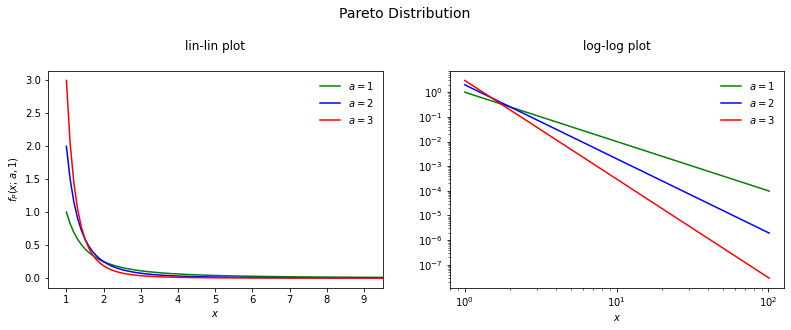

In [10]:
from scipy.stats import pareto

x = lambda a, m=1: np.linspace(m, m+100, 1000)
P = lambda a, m=1: pareto.pdf(x(a, m), a, loc=m-1)

fig,ax = plt.subplots(1,2, figsize=(6*2.2,4))
for a,c in zip([1,2,3], ['g','b','r']):
    ax[0].plot(x(a), P(a), '-'+c, label='$a={}$'.format(a))
    ax[1].loglog(x(a), P(a), '-'+c, label='$a={}$'.format(a))
for a_ in ax:
    a_.set_xlabel('$x$')
    a_.legend(frameon=False)
ax[0].set_xlim(.5, 9.5)
ax[0].set_ylabel('$f_P(x;a,1)$')
ax[0].set_title('lin-lin plot\n')
ax[1].set_title('log-log plot\n')
fig.suptitle('Pareto Distribution', y=1.1, fontsize=14)
plt.show()

## 2.2 Zipf distribution

If $x\in\mathbb{N}$ and supports $[m,M]$, a power law refers to the Zipf distribution $f_Z{(x;a,m,M)}$.

\begin{align*}
    f_Z{(x;a,m,M)} = \dfrac{x^{-a}}{\sum_{\xi=m}^M \xi^{-a}}
\end{align*}

The sum in its denominator shrinks to the $a$-th order harmonic number of $M$, i.e. $H_{M,a}$, for $m=1$. Some only refer to the Zipf distribution as the distribution with $m=1$ and call the one with $m\geq1$ the Zipf-Mandelbrot distribution instead.

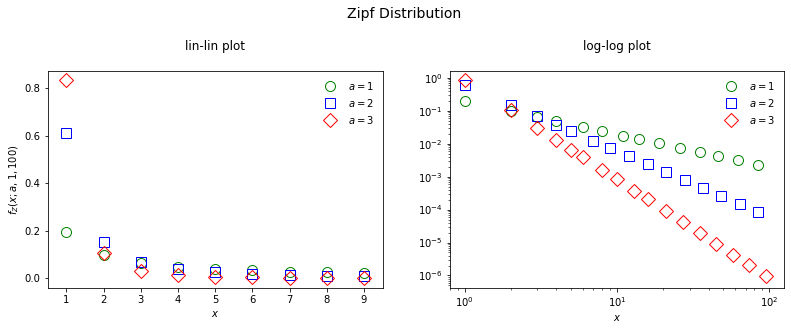

In [11]:
x = lambda M, m=1: np.arange(m, M+1, dtype=float)
Z = lambda a, M, m=1: x(M,m)**-a/(x(M,m)**-a).sum()

fig,ax = plt.subplots(1,2, figsize=(6*2.2,4))
for a,fmt in zip([1,2,3], ['go','bs','rD']):
    ax[0].plot(x(100), Z(a,100), fmt, ms=10, mfc='none', label='$a={}$'.format(a))
    ax[1].loglog(x(100), Z(a,100), fmt, ms=10, mfc='none',
                 markevery=.05, label='$a={}$'.format(a))
for a_ in ax:
    a_.set_xlabel('$x$')
    a_.legend(frameon=False)
ax[0].set_xlim(.5, 9.5)
ax[0].set_ylabel('$f_Z(x;a,1,100)$')
ax[0].set_title('lin-lin plot\n')
ax[1].set_title('log-log plot\n')
fig.suptitle('Zipf Distribution', y=1.1, fontsize=14)
plt.show()

## 2.3 Zeta distribution

If $x\in\mathbb{N}$ and supports $[m,\infty)$, a power law refers to the zeta distribution $f_\zeta{(x;a,m)}$.

\begin{align*}
    f_\zeta{(x;a,m)} = \dfrac{x^{-a}}{\zeta(a,m)}
                \equiv \dfrac{x^{-a}}{\sum_{\xi=0}^\infty (\xi+m)^{-a}}
\end{align*}

$\zeta(a,m)$ is called the Hurwitz zeta function, which generalizes the Riemann zeta function. Note that the zeta funciton and thus the distribution diverge at $a=1$.

You can learn more about it with `stats.zipf` (not anything like `.zeta`) from SciPy, which sets $m=1$ by default.

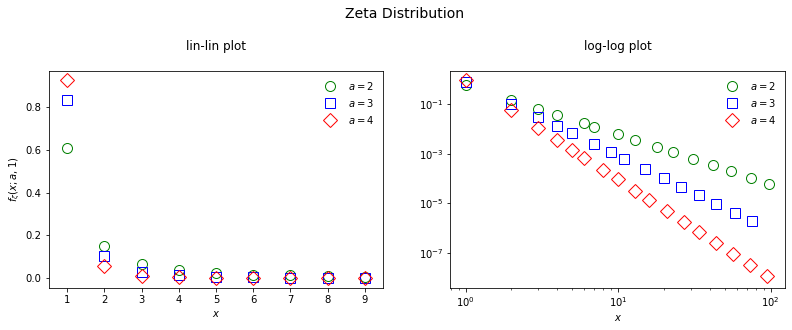

In [12]:
from scipy.stats import zipf as zeta

x = np.arange(1, 100)
Z_ = lambda a, m=1: zeta.pmf(x, a, loc=m-1)

fig,ax = plt.subplots(1,2, figsize=(6*2.2,4))
for a,fmt in zip([2,3,4], ['go','bs','rD']):
    ax[0].plot(x, Z_(a), fmt, ms=10, mfc='none', label='$a={}$'.format(a))
    ax[1].loglog(x, Z_(a), fmt, ms=10, mfc='none',
                 markevery=.05, label='$a={}$'.format(a))
for a_ in ax:
    a_.set_xlabel('$x$')
    a_.legend(frameon=False)
ax[0].set_xlim(.5, 9.5)
ax[0].set_ylabel('$f_\zeta(x;a,1)$')
ax[0].set_title('lin-lin plot\n')
ax[1].set_title('log-log plot\n')
fig.suptitle('Zeta Distribution', y=1.1, fontsize=14)
plt.show()

## 2.4 Exponential distribution

An exponential distribution $f_e{(x;a,m)}$ **does not belong to the power law family**. Although its lin-lin plot looks like that of the Pareto distribution, its tail decays much faster than one that obeys a power law. One may try to distinguish an exponential distribution by plotting both its log-log and log-lin plots.

\begin{align*}
    f_e{(x;a,m)} &= 
    \begin{cases}
        ae^{-a(x-m)} & (x\geq m) \\
        0 & (x<m)
    \end{cases} \\ \Rightarrow
    \ln f_e{(x;a,m)} &= 
    \begin{cases}
        -a(x-m)+\ln{a} & (x\geq m) \\
        \text{undefined} & (x<m)
    \end{cases}
\end{align*}

**Real world networks may exhibit as a mixture in between power law and exponential distribution**, i.e. not straight lines in both log-log and log-lin plots.

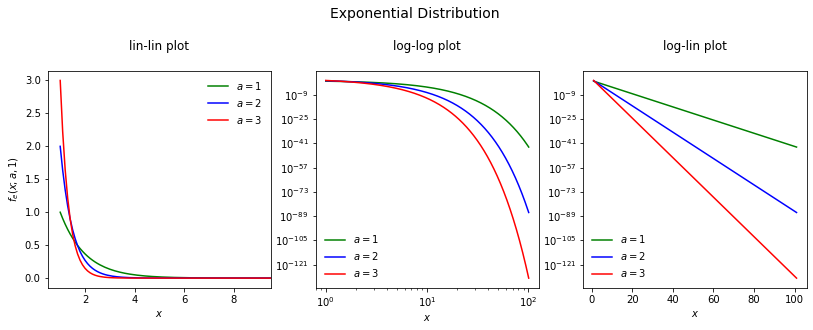

In [13]:
from scipy.stats import expon

x = lambda m=0: np.linspace(m, m+100, 1000)
E = lambda a, m=0: expon.pdf(x(m), loc=m, scale=1/a)

fig,ax = plt.subplots(1,3, figsize=(4*3.4,4))
for a,c in zip([1,2,3], ['g','b','r']):
    ax[0].plot(x(1), E(a), '-'+c, label='$a={}$'.format(a))
    ax[1].loglog(x(1), E(a), '-'+c, label='$a={}$'.format(a))
    ax[2].semilogy(x(1), E(a), '-'+c, label='$a={}$'.format(a))
for a_ in ax:
    a_.set_xlabel('$x$')
    a_.legend(frameon=False)
ax[0].set_xlim(.5, 9.5)
ax[0].set_ylabel('$f_e(x;a,1)$')
ax[0].set_title('lin-lin plot\n')
ax[1].set_title('log-log plot\n')
ax[2].set_title('log-lin plot\n')
fig.suptitle('Exponential Distribution', y=1.1, fontsize=14)
plt.show()

---
# 3. Clustering

Now we shift our focus to another network $\mathcal{S}$, [a semantic network of Charles Dickens's novel, *David Copperfield*](http://www-personal.umich.edu/~mejn/netdata/adjnoun.zip) [Newman, M. E. J.: Finding community structure in networks using the eigenvectors of matrices. Phys. Rev. E 74, 036104 (2001)]. Each node represents either an adjective or a noun, and two nodes are connected if they have appeared at least once together in the novel.

In [14]:
copperfield = nx.convert_node_labels_to_integers(nx.read_gml('data_set/adjnoun/adjnoun.gml'),
                                                 label_attribute='word')

N = copperfield.number_of_nodes()
E = copperfield.number_of_edges()
print('Number of nodes : '+str(N))
print('Number of edges : '+str(E))
print('Density of edges: {:.2e}'.format(nx.density(copperfield)))
print('Average degree  : {:.3g}'.format(sum(k for n,k in copperfield.degree)/N))

Number of nodes : 112
Number of edges : 425
Density of edges: 6.84e-02
Average degree  : 7.59


Note that the network is not bipartite. (E.g. "network model" is a noun phrase with two nouns appear together.)

The semantic network S is not bipartite.


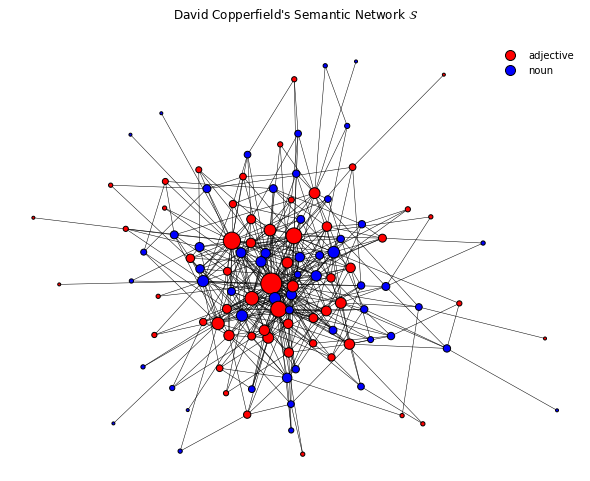

In [15]:
# value = 0: adjs, value = 1: nouns
adjs,nouns = nx.utils.groups(nx.get_node_attributes(copperfield, 'value')).values() 
degrees = nx.degree_centrality(copperfield)
symbols = [plt.plot(0, 0, c+'o', ms=10, mec='k')[0] for c in ['r', 'b']]
plt.close()

plt.figure(figsize=(8,6))
pos = nx.spring_layout(copperfield, seed=5056)
nx.draw(copperfield, pos=pos, edgecolors='k', width=.5,
        node_size=[degrees[n]*1000 for n in degrees],
        node_color=['r' if n in adjs else 'b' for n in degrees])
plt.legend(symbols, ['adjective', 'noun'], loc='best', frameon=False)
plt.title('David Copperfield\'s Semantic Network $\mathcal{S}$\n')

print('The semantic network S is {}bipartite.'
      .format('' if nx.is_bipartite(copperfield) else 'not '))

We would like to quantify the extent of a network's clustering, i.e. how much a node's neighbourhood correlate with its neighbours' ones. A network without any clusters is simply a tree, while trees can hardly model real networks (, otherwise your friends are never friends).

## 3.1 Local clustering coefficient

A node's clustering coefficient measures how probably its neighbours are connected and thus form a triangle. For a $k$-degree node with $e$ edges among its neighbours, its clustering coefficient reads

\begin{align*}
    c = \dfrac{2e}{k(k-1)}\,.
\end{align*}

As there are at most $C^k_2 = \dfrac{k(k-1)}{2}$ edges among $k$ nodes, $c$ definitely lie between $0$ and $1$. The higher a node's clustering coefficient is, the more probable its neighbours are connected. You can compute a node's clustering coefficient with `clustering()`, which returns a dictionary.

In [16]:
cs_adjs = nx.clustering(copperfield, adjs)
cs_nouns = nx.clustering(copperfield, nouns)
degrees = dict(copperfield.degree)

print([copperfield.degree[a] for a in adjs])
print(list(cs_adjs.values()))


[3, 33, 7, 11, 17, 4, 6, 12, 49, 14, 9, 13, 10, 9, 8, 28, 6, 3, 5, 10, 15, 28, 13, 3, 4, 2, 13, 5, 1, 12, 2, 6, 7, 1, 10, 12, 3, 3, 13, 8, 6, 2, 10, 6, 1, 1, 2, 3, 3, 5, 2, 2, 10, 9, 21, 7, 2, 4]
[0.6666666666666666, 0.13257575757575757, 0.2857142857142857, 0.2909090909090909, 0.10294117647058823, 0.16666666666666666, 0.26666666666666666, 0.22727272727272727, 0.11649659863945579, 0.18681318681318682, 0, 0.14102564102564102, 0.26666666666666666, 0.25, 0.25, 0.0873015873015873, 0.2, 0.3333333333333333, 0.1, 0.2222222222222222, 0.29523809523809524, 0.12962962962962962, 0.3076923076923077, 0, 0, 0, 0.14102564102564102, 0.1, 0, 0.15151515151515152, 0, 0.06666666666666667, 0.23809523809523808, 0, 0.17777777777777778, 0.07575757575757576, 0.3333333333333333, 0.3333333333333333, 0, 0.32142857142857145, 0.2, 1.0, 0.24444444444444444, 0.3333333333333333, 0, 0, 1.0, 0, 0, 0.4, 0, 0, 0.3111111111111111, 0.2222222222222222, 0.14285714285714285, 0.14285714285714285, 0, 0]


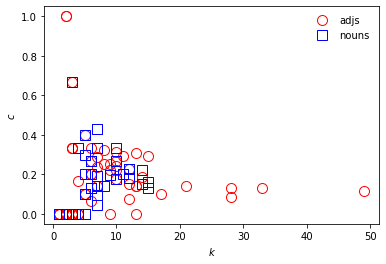

In [17]:
cs_adjs = nx.clustering(copperfield, adjs)
cs_nouns = nx.clustering(copperfield, nouns)
degrees = dict(copperfield.degree)

plt.figure(figsize=(6, 4))
plt.plot([copperfield.degree[a] for a in adjs],
         list(cs_adjs.values()), 'ro', ms=10, mfc='none', label='adjs')
plt.plot([copperfield.degree[n] for n in nouns],
         list(cs_nouns.values()), 'bs', ms=10, mfc='none', label='nouns')
plt.legend(frameon=False)
plt.xlabel('$k$')
plt.ylabel('$c$')
plt.show()

While the ordinary clustering coefficient measures the probability of triangles, the square clustering coefficient $c_4$ measures the probability measures the probability of squares, i.e. how probably a node's neighbours share other common neighbours. You may compute this less popular quantity with `square_clustering()`.

You may even generalize the quantity to the probability of $n$-gons, but it is unlikely useful as $n$ grows.

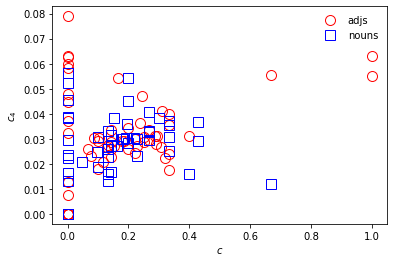

In [18]:
c4s_adjs = nx.square_clustering(copperfield, adjs)
c4s_nouns = nx.square_clustering(copperfield, nouns)
degrees = dict(copperfield.degree)

plt.figure(figsize=(6, 4))
plt.plot(list(cs_adjs.values()), list(c4s_adjs.values()), 'ro', ms=10, mfc='none', label='adjs')
plt.plot(list(cs_nouns.values()), list(c4s_nouns.values()), 'bs', ms=10, mfc='none', label='nouns')
plt.legend(frameon=False)
plt.xlabel('$c$')
plt.ylabel('$c_4$')
plt.show()

## 3.2 Transitivity

A network's transitivity $C_\Delta$ measures how probably three nodes form a triangle if they already form a triad, i.e. a V-shaped structure. The qualitative definition of $C_\Delta$ reads

\begin{align*}
    C_\Delta = 3\times\dfrac{\text{#triangles}}
                            {\text{#triads}}\,,
\end{align*}

where the leading factor compensates the fact that each triangle comprises three triads. One may rewrite the definition with the network's adjacency matrix $\mathbf{A}$:

\begin{align*}
    C_\Delta = \dfrac{\mathrm{tr}\left(\mathbf{A}^3\right)}
                     {\sum_{i\neq j}\left(\mathbf{A}^2\right)_{ij}}\,.
\end{align*}

Recall that multiplying by adjacency matrix is equivalent to counting the number ways to travel to neighbouring nodes. So 
- $\mathbf{A}^2 \sim$ no. of ways of travelling to one of your next-next neighbour, i.e. no. of triples of (initial - neighbour - next next neighbour).
- $\mathrm{tr}(\mathbf{A}^3) \sim$ no. of ways of travelling back to initial position after 3 steps, i.e. no. of triangles.

In NetworkX, you can compute the quantity with `transitivity()`. On the other hand, While some refer to a network's clustering coefficient $C$ as its transitivity $C_\Delta$, some actually refer to $C$ as the network's average clustering coefficeint $\langle{c}\rangle$, which you can compute with `average_clustering()`.

\begin{align*}
    C_\Delta &\sim \dfrac{\sum_i \text{# triangles involving $i$}}
                         {\sum_i \text{# triads involving $i$}} \\ \\
    \langle{c}\rangle
             &\sim \sum_i \dfrac{\text{# triangles involving $i$}}
                                {\text{# triads involving $i$}}
\end{align*}

The two quantities generally differ although they both count triangles. This occurs due to their formal difference: $C_\Delta$ is a ratio of sums, whereas $\langle{c}\rangle$ amounts to an average of fractions.

In [19]:
nx.transitivity(copperfield), nx.average_clustering(copperfield)

(0.15693497881746177, 0.1728400798103679)

## 3.3 Reciprocity

On directed networks, one may measure reciprocity $R$, i.e. the probability that there are mutual connections between two nodes, e.g. Both the links $A\rightarrow B$ and $B\rightarrow A$ exist. The number is normalized by the total number of links $2E$, where $E$ is the number of edge and 2 is for double counting bidirectional edges.

\begin{align*}
    R = \dfrac{1}{2E} \text{tr}\left(\mathbf{A}^2\right)
\end{align*}

An undirected network's reciprocity is trivially $1$ if each undirected edge is interpreted as a bidirected link. However, NetworkX's method `reciprocity()` definitely returns zero if the input graph is undirected.

In [20]:
print('Undirected: {}'.format(nx.reciprocity(copperfield)))
print('Directed: {}'.format(nx.reciprocity(copperfield.to_directed())))

# transform edges between adjs and nouns
# to directed links from adjs to nouns
# otherwise keep both directed links
CD = copperfield.to_directed()
for u,v in copperfield.edges:
    if u in nouns and v in adjs:
        CD.remove_edge(u, v)

nx.reciprocity(CD)

Undirected: 0.0
Directed: 1.0


0.7388724035608308

---
# 4. Assortativity

Assortativity measures how a node's identity affects its neighbourhood. At the two extreme ends:

- An assortative network has "homophilic" nodes, which tend to connect to nodes similar to themselves;
- A dissortative network has "heterophilic" nodes, which tend to connect to nodes different from themselves. 

The similarity between nodes can be defined either 
- Categorically, e.g. distinguishable as distinct classes.
- Quantitatively, e.g. each nodes carry some continuous variables, and similarity is measured by the how close the values are.

## 4.1 Categorical assortativity

Categorical assortativity defines inter-node similiarity with nodes' classes. If the $N$ nodes in a network are classified into $p$ classes, the network's assorativity coefficient amounts to

\begin{align*}
    r_c = \dfrac{\sum_{s=1}^p e_{ss} - \sum_{s=1}^p a_sb_s}
                {1-\sum_{s=1}^p {a_sb_s}}\,,
\end{align*}

where 

- $e_{ss}$ = *fraction* of edges that connects two nodes from the same class $s$
- $a_s\equiv\sum_{t\neq s}{e_{st}}$ = *fraction* of edges starting from $s$, but ending in any classes $t$ other $s$
- $b_s\equiv\sum_{t \neq s}{e_{ts}}$ = *fraction* of edges ending at $s$, but starting in any classes $t$ other $s$


If the network is undirected, $e_{st}=e_{ts}$, so $a_s=b_s$ and $a_sb_s=a_s^2$.

- For a perfectly assortative network, whose edges only connect nodes of the same class, has $r_c=1$, 
- A network has "neutral" assortativity if $r_c=0$, by $e_{ss}$ is expected to equal $a_sb_s$ (i.e. edges are equally probable to connect same classes and different classes.)
- Interestingly, a perfectly dissortative network, whose edges always connect nodes of different classes, has $r_c\in\left[-1,0\right)$ instead of $r_c=-1$, i.e. it may not hit $-1$ even if the network is perfectly dissortative. This intuitively means that a perfectly dissortative network is "closer" to a random network than a perfectly assortative network is. (Read [Newman, M. E. J., Mixing patterns in networks. Phys. Rev. E, 67, 026126 (2003)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.67.026126) for more discussion on this intuition.)

You can compute $r_c$ with `attirbute_assortativity_coefficient()`.

In [21]:
nx.attribute_assortativity_coefficient(copperfield, 'value')

-0.5060450250138964

The negative value means that the semantic network is dissortative. This makes sense because adjectives pair up with nouns more frequently than with adjectives, so do nouns with adjectives than with nouns.

Alternatively, you can get the matrix $\mathbf{e}=\left[e_{ij}\right]$ with `attribute_mixing_matrix()`, which helps rewrite the definition of $r_c$ as:

\begin{align*}
    r_c = \dfrac{\text{tr}{\,\mathbf{e}} - \lVert \mathbf{e}^2 \rVert}
                {1 - \lVert \mathbf{e}^2 \rVert}\,,
\end{align*}

where $\lVert\cdot\rVert$ sums up the elements of the matrix enclosed.

In [22]:
e = nx.attribute_mixing_matrix(copperfield, 'value')
print(e)
(e.trace()-(e@e).sum())/(1-(e@e).sum())

[[0.24470588 0.36      ]
 [0.36       0.03529412]]


-0.5060450250138964

## 4.2 Modularity

The nominator of $r_c$ is commonly called the modularity $Q$, which one may calculate with a different formulation. 

\begin{align*}
    Q = \dfrac{1}{2m} \sum_{i,j} \left( A_{ij} - \dfrac{k_ik_j}{2m} \right) \delta \left(c_i, c_j\right)\,,
\end{align*}

Let's break down this formula bit by bit for clearer understanding:

- $\dfrac{k_ik_j}{2m}$ = Probability of finding an edge that connect a node of degree $k_i$ and another node of degree $k_j$. Here $m$ is the total number of edges in the network. This result is derived from random network. We will encounter this again in lecture 6.

- $A_{ij}$ = Elements in adjacency matrix, i.e. $1$ if there actually an edge between node $i$ and $j$, and $0$ if not.

- $\delta\left(c_i,c_j\right)=\begin{cases} 1 & \text{if }c_i=c_j \\ 0 & \text{if } c_i\neq c_j\end{cases}$. i.e. Count into the sum only if the classes of the two nodes are equal. 

Therefore modularity is a measure that is 

- $Q>0$ if actual no. of edges between same classes > average
- $Q<0$, if actual no. of edges between same classes < average

This formulation is equivalent to the original formulation by

\begin{align*}
    \begin{cases}
        e_{st} &= &\dfrac{1}{2E} \sum_{i,j} A_{ij} \delta\left(c_i,s\right) \delta\left(c_j,t\right) \\ 
           a_s &= &\dfrac{1}{2E} \sum_i k_i \delta \left(c_i,s\right)\,
    \end{cases}\,.
\end{align*}

Additionally, we may reformulate $Q$ in matrix form: 

1. Define the modularity matrix $\mathbf{B}=\mathbf{A}-\dfrac{1}{2E}kk^\intercal$, where $k=\left(\matrix{k_1\\\vdots\\k_N}\right)$

2. A class matrix $\mathbf{\Delta}_{N\times p}=[\Delta_{is}]$. 
    - Dimension = $N\times p$ = (Total number of node) $\times$ (Number of class)
    
    - Each element = $\Delta_{is}=\begin{cases}1 & \text{if node } i \text{ belong to class } s\\0 & \text{else}\end{cases}$
    
Then $Q$ can be written as

\begin{align*}
     Q = \dfrac{1}{2E}\,\text{tr}{\,\left(\mathbf{\Delta}^\intercal \mathbf{B} \, \mathbf{\Delta}\right)}\,.
\end{align*}

You can also get the modularity matrix $\mathbf{B}$ with `modularity_matrix()`.

In [23]:
B = nx.modularity_matrix(copperfield)
D = np.array([[float(i in c) for c in [adjs, nouns]] for i in copperfield.nodes])
M = ((D.T@B@D).trace()/(2*E)).item()
M, e.trace()-(e@e).sum()

(-0.2419266435986159, -0.24192664359861582)

## 4.3 Quantitative assortativity

On the contrary to categorical assortativity, quantitative assortativity is associated with some continuous property $q$. One may measure quantitative assortativity with the Pearson correlation coefficient, which resemble a similar formula to categorical assortativity:

\begin{align*}
r_q = \frac{\sum_x\sum_y (e_{xy} - a_xb_y)}{\sigma_x\sigma_y}
\end{align*}

where

- $e_{xy}$ = *fraction* of edges that connects a node carrying property $q=x$ to a node carrying property $q=y$
- $a_x\equiv\sum_{y}{e_{xy}}$ = *fraction* of edges starting from a node carrying property $q=x$
- $b_y\equiv\sum_{x}{e_{xy}}$ = *fraction* of edges ending at a node carrying property $q=y$
- $\sigma_x, \sigma_y$ are SD to the distribution of $a_x$ and $b_y$ respectively



You can compute $r_q$ with `numeric_assortativity_coefficient()`. Particularly, you may use `degree_assortativity_coefficient()` if the quantitive attribute that you are measuring is a node's degree.

In [24]:
for n,d in copperfield.nodes(data=True):
    d['degree'] = copperfield.degree[n]

(nx.numeric_assortativity_coefficient(copperfield, 'degree'),
 nx.degree_assortativity_coefficient(copperfield))

(-0.12934785343900138, -0.12934785343900138)

An alternatively definition of $r_q$ employs the modularity matrix $\mathbf{B}$ and the Laplacian matrix $\mathbf{L}$.

\begin{align}
    r_q = \dfrac{q^\mathrm{T}\,\mathbf{B}\,q}
                {q^\mathrm{T}\left(\mathbf{B}+\mathbf{L}\right)q}
    \,\,\text{with}\,\,
    q = \left(\matrix{q_1\\\vdots\\q_N}\right)
\end{align}

In [25]:
L = nx.laplacian_matrix(copperfield)
k = np.array([[k] for n,k in nx.degree(copperfield)])
((k.T@B@k)/(k.T@(B+L)@k)).item()

-0.1293478534390013

## 4.4 Degree correlation

If $q$ measures a node's degree $k$, the correlation coefficient $r_q$ describes a network's degree correlation, whose sign helps us judge if the nodes assort accoding to degree. Alternatively, one may determine a network's degree assortativity with its correlation exponent $\mu$.

ALthough a node $i$'s average-neighbour-degree $k'_i=\langle{A_{ij}k_j}\rangle$, the expected averaged-neighbour-degree $\hat{k^\prime}(k)$ of a $k$-degree node reads

\begin{align}
    \hat{k^\prime}(k) = \dfrac{\sum_i k^\prime_i\,\delta\left(k_i, k\right)}
                              {\sum_i \delta\left(k_i, k\right)}\,.
\end{align}

- Assortative network: $\hat{k^\prime}$ increases with $k$, as connected nodes tend to have similar degrees
- Dissortative network: $\hat{k^\prime}$ decreases as $k$ grows, just the opposite way

The special case is a neutral network, on which $\hat{k^\prime}$ is a constant: $\hat{k^\prime}=\dfrac{\langle{k^2}\rangle}{\langle{k}\rangle}$. If we "assume" that $\hat{k^\prime}$ obeys a power law, i.e. $\hat{k^\prime} \sim k^\mu$ with a correlation exponent $\mu$, the sign of $\mu$ implies a network's assortativity as that of $r_q$ does. (You may check [Barabási, A.-L., Network Science. Cambridge University Press, Cambridge (2016)](http://networksciencebook.com/chapter/7) for a more rigorous discussion.)

You can compute $k^\prime$ with `average_degree_connectivity()`.

estimated correlation exponent: μ = -0.125


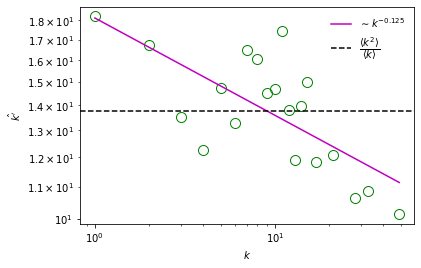

In [26]:
kHat = nx.average_degree_connectivity(copperfield)
kRng = np.arange(min(kHat), max(kHat)+1)

mu,c = np.polyfit(np.log(list(kHat.keys())),
                  np.log(list(kHat.values())), 1)
print('estimated correlation exponent: μ = {:.3g}'.format(mu))

plt.figure(figsize=(6,4))
plt.loglog(list(kHat.keys()), list(kHat.values()), 'go', ms=10, mfc='none')
plt.plot(kRng, kRng**mu*np.exp(c), 'm-',
         label='$\sim k^{'+'{:.3g}'.format(mu)+'}$')
plt.axhline(sum(k**2 for n,k in copperfield.degree)/
            sum(k for n,k in copperfield.degree), color='k', ls='--',
            label=r'$\dfrac{\langle{k^2}\rangle}{\langle{k}\rangle}$')
plt.xlabel('$k$')
plt.ylabel('$\hat{k^\prime}$')
plt.legend(frameon=False)
plt.show()